In [17]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
import seaborn as sns

In [7]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-26' and '2022-10-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df


,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [12]:
p_value_list = []
for _ in range(10000):
    p_val = stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500,replace=False),
            df[df.exp_group == 3].ctr.sample(500,replace=False),
            equal_var=False)[1] #p-value
    p_value_list.append(p_val)
    

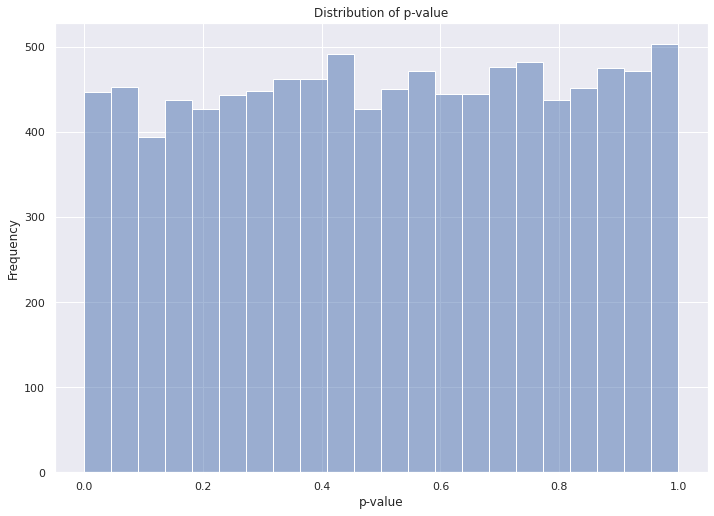

In [29]:
fig, ax1 = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = p_value_list,   
              alpha=0.5,
              kde=False)
ax1.set_title(r'Distribution of p-value')
ax1.set_xlabel(r'p-value')
ax1.set_ylabel(r'Frequency')
plt.show()

In [33]:
frp = 0
for i in p_value_list:
    if i < 0.05:
        frp+=1
print(f'Количество ложных срабатываний равно: {(frp/10000)*100}%, что не превышает установленный уровень α = 5%.')
    

Количество ложных срабатываний равно: 4.91%, что не превышает установленный уровень α = 5%.


Наша система сплитования работает **корректно**. Мы получили практически равномерное распределение **p-value**, что говорит нам о том, что нулевые гипотезы верны. То есть средние двух групп равны, а значит группы одинаковые. Теперь мы спокойно можем провести AB тестирование.